# Support Vector Machines - Baseline Model


In [ ]:
import os
from skimage.feature import hog
from skimage import exposure
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
import cv2

import seaborn as sns
import matplotlib.pyplot as plt




In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Set the path to the data
base_path = ''


In [ ]:
# Define the HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
fixed_length = 352836


In [ ]:
# Initialize lists to store HOG features and labels for training data
hog_features_train = []
labels_train = []


In [ ]:
# Specify the list of classes (folders)
classes = ["zipper", "wood", "transistor", "toothbrush", "tile", "screw", "pill", "metal_nut", "leather", "hazelnut", "grid", "carpet", "capsule", "cable", "bottle"]


In [ ]:
def load_and_preprocess_image(image_path, target_size=(180, 180)):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # Normalize the pixel values to the [0, 1] range
    image = image.astype("float32") / 255.0
    return image

In [ ]:
# HOG features and labels for test data
for class_name in classes:
    train_folder = os.path.join(base_path, class_name, "train", "good")

    for filename in os.listdir(train_folder):
        image_path = os.path.join(train_folder, filename)
        image = load_and_preprocess_image(image_path, target_size=(180, 180))

        features = hog(image, orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys',
                       visualize=False,
                       multichannel=True)

        if len(features) < fixed_length:
            features = np.pad(features, (0, fixed_length - len(features)))
        elif len(features) > fixed_length:
            features = features[:fixed_length]

        hog_features_train.append(features)
        labels_train.append(1)

hog_features_train = np.array(hog_features_train)
labels_train = np.array(labels_train)

<ipython-input-8-08d7b047e1b5>:9: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features = hog(image, orientations=orientations,


In [ ]:
# Check dimensions of features
distinct_dimensions = set()

for features in hog_features_train:
    dimension = features.shape
    distinct_dimensions.add(dimension)


for dim in distinct_dimensions:
    print(dim)

print(len(hog_features_train))



(352836,)
3629


In [ ]:
# Set random seed for scikit-learn
random_seed = 42
np.random.seed(random_seed)

In [ ]:
# Initialize the SVM classifier
clf = svm.OneClassSVM(kernel='rbf', gamma='scale')

# Train the classifier on the training data
clf.fit(hog_features_train)

OneClassSVM()

In [ ]:
# HOG features and labels for test data
hog_features_test = []
labels_test = []

for class_name in classes:
    test_folder = os.path.join(base_path, class_name, "test")

    for folder_name in os.listdir(test_folder):
        defect_folder = os.path.join(test_folder, folder_name)

        for filename in os.listdir(defect_folder):
            image_path = os.path.join(defect_folder, filename)
            image = load_and_preprocess_image(image_path, target_size=(180, 180))


            features = hog(image, orientations=orientations,
                           pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block,
                           block_norm='L2-Hys',
                           visualize=False,
                           multichannel=True)


            if len(features) < fixed_length:
                features = np.pad(features, (0, fixed_length - len(features)))
            elif len(features) > fixed_length:
                features = features[:fixed_length]

            hog_features_test.append(features)

            if folder_name == "good":
                labels_test.append(1)
            else:
                labels_test.append(-1)

hog_features_test = np.array(hog_features_test)
labels_test = np.array(labels_test)


<ipython-input-14-ba1a43bcacf7>:16: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  features = hog(image, orientations=orientations,


In [ ]:
# Check dimensions of features
distinct_dimensions_test = set()

for features in hog_features_test:
    dimension_test = features.shape
    distinct_dimensions_test.add(dimension)


for dim in distinct_dimensions_test:
    print(dim)

print(len(hog_features_test))


(352836,)
1725


In [ ]:
y_pred = clf.predict(hog_features_test)

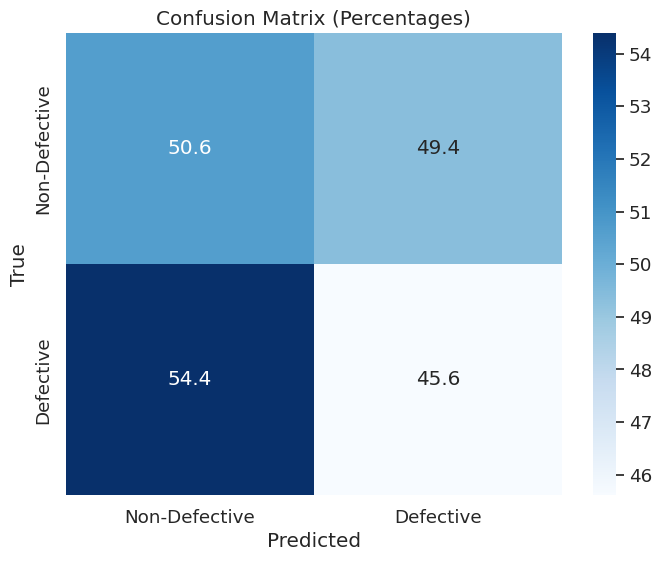

Confusion Matrix:
[[637 621]
 [254 213]]
True Positives (TP): 213
False Positives (FP): 621
True Negatives (TN): 637
False Negatives (FN): 254
Precision: 0.255
Accuracy: 0.493
Recall: 0.456
F1-Score: 0.327


In [ ]:
# Create the confusion matrix
confusion_mat = confusion_matrix(labels_test, y_pred)

# Calculate TP, FP, TN, FN values
TP = confusion_mat[1, 1]
FP = confusion_mat[0, 1]
TN = confusion_mat[0, 0]
FN = confusion_mat[1, 0]

# Calculate precision, recall, and F1-score
precision = TP / (TP + FP)
accuracy = (TP + TN)/(TP + FP + TN + FN)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a confusion matrix plot (percentages)
cm_percentage = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Non-Defective", "Defective"],
            yticklabels=["Non-Defective", "Defective"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentages)')
plt.show()

# Print confusion matrix and metrics
print("Confusion Matrix:")
print(confusion_mat)
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")
print(f"Precision: {precision:.3f}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1_score:.3f}")
